In [1]:
import numpy as np
import pickle

import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

# from name_dataset import NameDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

# Loading data

In [2]:
with open('/kaggle/input/urbansound8k-feature-extraction/train_data.pkl', 'rb') as f:
    X_train, Y_train = pickle.load(f)

with open('/kaggle/input/urbansound8k-feature-extraction/val_data.pkl', 'rb') as f:
    X_val, Y_val = pickle.load(f)


In [3]:
import pandas as pd
import numpy as np

def stack_samples(X, Y):
    """
    X: list or array of shape (N, R, C)
    Y: list of N labels
    Returns: DataFrame of shape (N×R, C + 1)
    """
    X_np = np.array(X, dtype=np.float32)  # Shape: (N, R, C)
    Y_repeated = np.repeat(Y, X_np.shape[1])  # Repeat each label R times

    X_stacked = X_np.reshape(-1, X_np.shape[2])  # (N×R, C)

    df = pd.DataFrame(X_stacked)
    df['labels'] = Y_repeated

    return df

train_df = stack_samples(X_train, Y_train)
val_df = stack_samples(X_val, Y_val)
print(train_df.shape)
print(val_df.shape)

(1173960, 181)
(355104, 181)


In [4]:
train_df.head(54)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,labels
0,0.027114,0.069684,0.084108,0.086272,0.086115,0.068998,0.075101,0.081550,0.082987,0.075951,...,0.078393,0.053319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
1,0.430208,5.758408,51.152721,60.381077,21.515299,4.466881,13.074950,55.018288,43.365993,16.410397,...,25.460247,5.669981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
2,0.356129,2.768868,10.043193,5.306677,2.211567,2.200262,5.633092,11.511503,4.667964,2.912486,...,5.367310,2.295357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
3,0.119155,0.518129,1.104150,0.707675,0.361656,0.435153,0.531613,1.172129,1.274063,1.586210,...,1.393059,0.565431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
4,0.200908,0.502827,0.919906,0.679136,0.617777,0.499163,0.740346,0.879904,0.768322,0.788436,...,1.237146,0.505317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
5,0.170222,0.579005,0.849931,0.902989,0.607756,0.673738,0.697245,1.517281,1.158525,0.456944,...,0.783423,0.195463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
6,0.110933,0.318491,1.234081,1.249484,1.085954,0.533614,0.550653,1.347195,0.960807,0.647482,...,0.694076,0.386585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
7,0.164980,0.210829,0.551717,1.482775,2.704562,0.968102,0.979872,1.822335,2.469921,1.716560,...,1.440140,0.662305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
8,0.080657,0.206064,0.383828,0.475435,0.290516,0.347667,0.401557,0.537649,0.564168,0.395445,...,1.213662,0.555193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
9,0.067881,0.175669,0.380467,0.296372,0.141358,0.099105,0.360744,0.758478,0.346240,0.308535,...,0.190039,0.234406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer


In [5]:
val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,labels
0,0.044180,0.056054,0.064415,0.069324,0.067334,0.067759,0.071800,0.069728,0.069248,0.065749,...,0.070372,0.061280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
1,1.723533,5.687970,9.228014,7.410962,7.198935,11.340713,7.369151,10.589535,10.131034,3.039403,...,14.573446,10.166873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
2,2.469047,7.855614,10.789010,9.705440,11.964504,14.177218,9.775521,12.749818,11.203400,4.147494,...,12.323687,5.084070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
3,2.648386,5.412858,5.202138,6.334105,10.531077,8.599378,4.707143,6.276899,5.755446,8.934631,...,10.442652,4.127263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer
4,0.576799,1.618431,2.621299,1.711736,1.985173,2.103726,1.531987,2.888803,3.074646,3.813351,...,4.061364,3.374841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jackhammer


# Dataset Loader

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
BATCH_SIZE = 32
N_WORKERS = torch.cuda.device_count() if torch.cuda.device_count() > 1 else 1
N_WORKERS

2

In [8]:
label_map = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9
}

In [134]:
class UrbanSound8kDataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self, file_path):
        with open(file_path, 'rb') as f:
            self.x_data, self.y_data = pickle.load(f)
        self.len = len(self.x_data)
        self.y_data = np.array([label_map[label] for label in self.y_data])

    def __getitem__(self, idx):
        x = self.x_data[idx].astype(np.float32)   # <- fix here
        y = self.y_data[idx]
        # print(type(x[0][0]))
        # print(y)
        # print(torch.tensor(y, dtype=torch.long))
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.len


In [139]:
class UrbanSound8kDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, 'rb') as f:
            self.x_data, self.y_data = pickle.load(f)
        self.y_data = np.array([label_map[label] for label in self.y_data])
        self.len = len(self.x_data)

        # Convert to float32 for safety
        self.x_data = self.x_data.astype(np.float32)

        # Stack to shape (21740, 54, 180)
        data_stack = self.x_data

        # Compute mean and std over samples and time axis, for each feature
        # Result shape: (54, 1)
        self.mean = data_stack.mean(axis=(0, 2), keepdims=True)
        self.std = data_stack.std(axis=(0, 2), keepdims=True) + 1e-8

        # Normalize: (sample - mean) / std
        self.x_data = (self.x_data - self.mean) / self.std

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.len


In [140]:
train_dataset = UrbanSound8kDataset('/kaggle/input/urbansound8k-feature-extraction/train_data.pkl')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)
val_dataset = UrbanSound8kDataset('/kaggle/input/urbansound8k-feature-extraction/val_data.pkl')
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)


In [141]:
print(len(train_dataset), len(train_dataset[0]), len(train_dataset[0][0]), len(train_dataset[0][0][0]))

21740 2 54 180


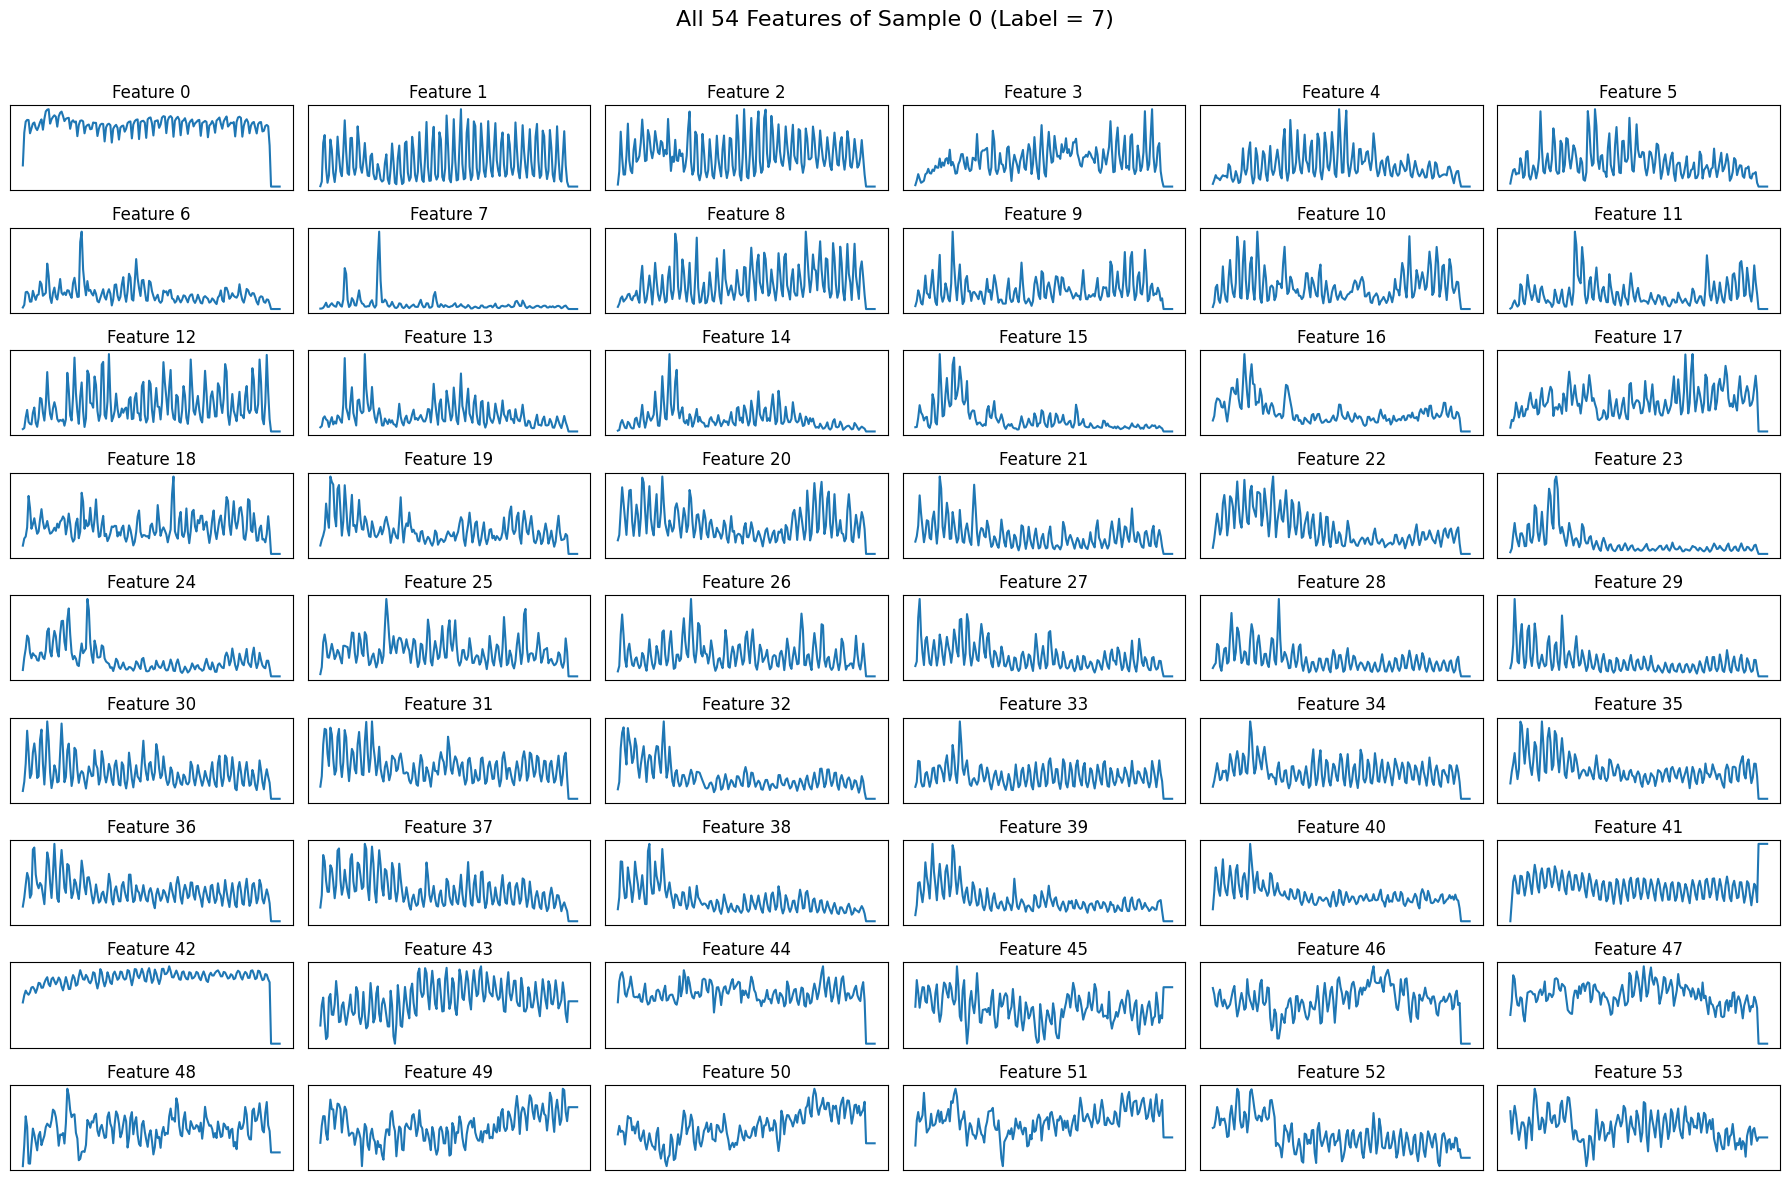

In [218]:
import matplotlib.pyplot as plt

# Get the first sample
x, y = train_dataset[1]
x = x.numpy()  # shape: (54, 180)

fig, axs = plt.subplots(9, 6, figsize=(18, 12))  # 9 rows, 6 columns
fig.suptitle(f"All 54 Features of Sample 0 (Label = {y})", fontsize=16)

for i in range(54):
    row, col = divmod(i, 6)
    axs[row, col].plot(x[i])
    axs[row, col].set_title(f"Feature {i}")
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


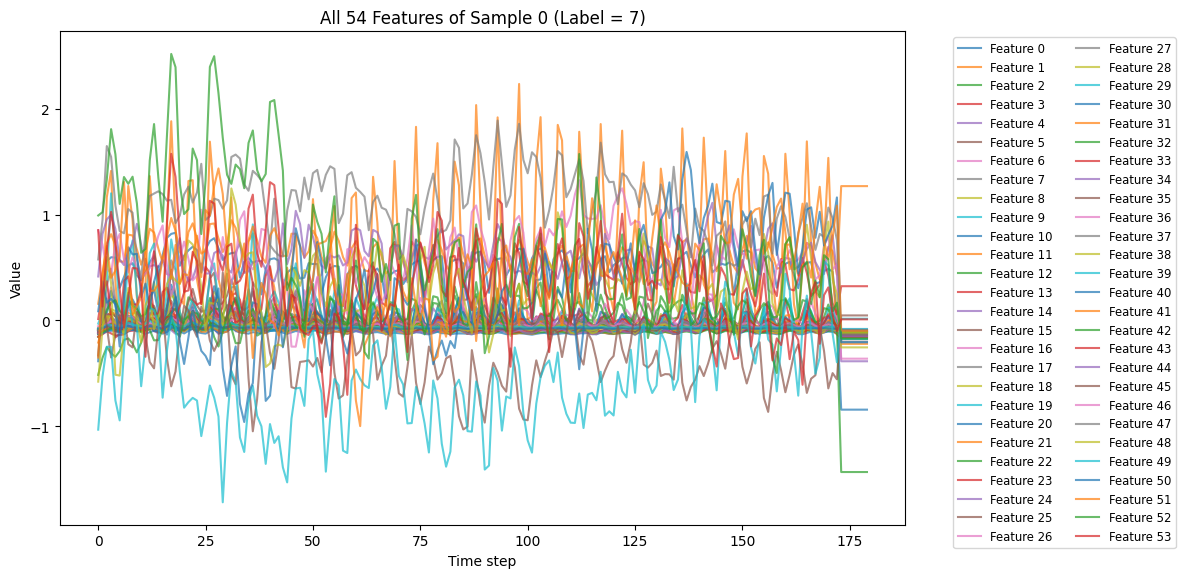

In [219]:
plt.figure(figsize=(12, 6))
for i in range(54):
    plt.plot(x[i], label=f'Feature {i}', alpha=0.7)

plt.title(f"All 54 Features of Sample 0 (Label = {y})")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [144]:
print(len(train_dataset), len(train_dataset[1]), train_dataset[1][1])

21740 2 tensor(7)


In [145]:
print(len(val_dataset), len(val_dataset[0]), len(val_dataset[0][0]), len(val_dataset[0][0][0]))

6576 2 54 180


In [146]:
print(len(val_dataset), len(val_dataset[1]), val_dataset[1][1])

6576 2 tensor(7)


# RNN Model

In [147]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = int(bidirectional) + 1

        self.projection = nn.Linear(input_size, hidden_size)
        self.rnn1 = nn.RNN(hidden_size, hidden_size, n_layers,
                          bidirectional=bidirectional, batch_first=True)
        # self.rnn2 = nn.RNN(hidden_size * self.n_directions, hidden_size, n_layers,
        #                   bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * self.n_directions, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, signal):
        # Note: we run this all at once (over the whole input sequence)
        # input shape: B x S (input size)
        # transpose to make S(sequence) x B (batch)
        # input = input.t()
        batch_size = signal.size(0)
        signal = signal.permute(0, 2, 1)

        # Make a hidden
        hidden = self._init_hidden(batch_size, signal.device)
        # print("hidden shape: ", hidden.shape)
        # print("signal shape: ", signal.shape)
        # # Embedding S x B -> S x B x I (embedding size)
        # embedded = self.embedding(input)

        # # Pack them up nicely
        # gru_input = pack_padded_sequence(
        #     embedded, seq_lengths.data.cpu().numpy())

        # To compact weights again call flatten_parameters().
        # self.gru.flatten_parameters()
        output, hidden = self.rnn1(self.projection(signal), hidden)
        # print("output shape: ", output.shape)
        # print("hidden shape: ", hidden.shape)
        # output, hidden = self.rnn2(output, hidden)

        if self.n_directions == 2:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        
        # print("hidden shape: ", hidden.shape)
        # New
        hidden = self.fc1(hidden)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        
        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc2(hidden)
        # print("fc_output shape: ", fc_output.shape)
        
        return fc_output

    def _init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.n_layers * self.n_directions,
                             batch_size, self.hidden_size).to(device)
        return create_variable(hidden)

In [174]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        self.bidirectional = bidirectional

        self.projection = nn.Linear(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                          bidirectional=bidirectional, batch_first=True, dropout=0.2)
        
        self.fc1 = nn.Linear(hidden_size * self.n_directions, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 2, 1)  # Make it [B, S, I]

        
        h0 = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size).to(x.device)
        out, hn = self.rnn(self.projection(x), h0)

        if self.bidirectional:
            hn = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            hn = hn[-1]

        x = self.fc1(hn)
        x = self.relu(x)
        x = self.fc2(x)

        return x


In [ ]:
import torch
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        self.bidirectional = bidirectional

        self.projection = nn.Linear(input_size, hidden_size)
        self.bn_input = nn.LayerNorm(hidden_size)  # For input after projection

        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                          bidirectional=bidirectional, batch_first=True, dropout=0.2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size * self.n_directions, hidden_size)
        self.bn_fc = nn.LayerNorm(hidden_size)     # For fc1 output
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0, 2, 1)  # [B, T, F] → [B, S, I]

        # Input projection
        x = self.projection(x)  # shape: [B, S, H]

        # BatchNorm on input: needs [B*S, H]
        x = self.bn_input(x.reshape(-1, x.shape[-1])).reshape(batch_size, -1, self.hidden_size)

        # RNN
        h0 = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)

        # Take last hidden state(s)
        if self.bidirectional:
            hn = torch.cat((hn[-2], hn[-1]), dim=1)  # [B, 2*H]
        else:
            hn = hn[-1]  # [B, H]

        # FC → BN → ReLU → FC
        x = self.fc1(hn)
        x = self.bn_fc(x)
        x = self.dropout(self.relu(x))
        x = self.fc2(x)

        return x


In [ ]:
# Train cycle
def train():
    total_loss = 0

    for i, (signal, label) in enumerate(train_loader, 1):
        output = classifier(signal)
        # print("signal size: ", signal.shape)
        # print("label size: ", label.shape)
        # print("label: ", label)
        loss = criterion(output, label)
        total_loss += loss.item()

        classifier.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.2f}'.format(
                time_since(start), epoch,  i *
                len(signal), len(train_loader.dataset),
                100. * i * len(signal) / len(train_loader.dataset),
                total_loss / i * len(signal)))

    return total_loss

In [ ]:
def train():
    classifier.train()
    total_loss = 0

    for i, (signal, label) in enumerate(train_loader, 1):
        signal = signal.to(device)
        label = label.to(device)

        output = classifier(signal)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * signal.size(0)

        if i % 100 == 0:
            avg_loss = total_loss / (i * signal.size(0))
            print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                time_since(start), epoch, i * len(signal),
                len(train_loader.dataset),
                100. * i * len(signal) / len(train_loader.dataset),
                avg_loss))

    classifier.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for signal, label in train_loader:
            signal = signal.to(device)
            label = label.to(device)
            

            output = classifier(signal)
            total_loss += criterion(output, label).item() * signal.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == label).sum().item()
            total += label.size(0)

    accuracy = 100. * correct / total
    print('Train set: Accuracy: {}/{} ({:.2f}%)\n'.format(correct, total, accuracy))


In [198]:
# Testing cycle
def test(name=None):
    
    print("evaluating trained model ...")
    correct = 0
    total_loss = 0
    train_data_size = len(val_loader.dataset)

    for signal, label in val_loader:
        output = classifier(signal)
        pred = output.data.max(1, keepdim=True)[1]
        total_loss += criterion(output, label)
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, train_data_size, 100. * correct / train_data_size))
    print(f"Loss: {total_loss / len(val_loader.dataset)}")


In [199]:
def test(name=None):
    classifier.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for signal, label in val_loader:
            signal = signal.to(device)
            label = label.to(device)
            

            output = classifier(signal)
            total_loss += criterion(output, label).item() * signal.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == label).sum().item()
            total += label.size(0)

    accuracy = 100. * correct / total
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(correct, total, accuracy))
    print(f"Loss: {total_loss / len(val_loader.dataset)}\n\n")

# Some utility functions

In [200]:
def create_variable(tensor):
    # Do cuda() before wrapping with variable
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

In [201]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Model Training & Valuation

In [207]:
N_EPOCHS = 100

N_INPUT = 54
HIDDEN_SIZE = 128
N_CLASSES = 10
N_LAYERS = 2

classifier = RNNClassifier(
    input_size=N_INPUT,
    hidden_size=HIDDEN_SIZE,
    output_size=N_CLASSES,
    n_layers=N_LAYERS,
    # bidirectional=False
)


In [208]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [33, xxx] -> [11, ...], [11, ...], [11, ...] on 3 GPUs
    classifier = nn.DataParallel(classifier)

Let's use 2 GPUs!


In [209]:
if torch.cuda.is_available():
    classifier.cuda()

In [210]:
test()


Test set: Accuracy: 683/6576 (10.39%)

Loss: 2.3093840002723565




In [211]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

start = time.time()
print("Training for %d epochs..." % N_EPOCHS)
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    train()

    # Testing
    test()

Training for 100 epochs...
 1s] Train Epoch: 1 [3200/21740 (15%)]	Loss: 1.6651
 2s] Train Epoch: 1 [6400/21740 (29%)]	Loss: 1.5071
 4s] Train Epoch: 1 [9600/21740 (44%)]	Loss: 1.3991
 5s] Train Epoch: 1 [12800/21740 (59%)]	Loss: 1.3028
 6s] Train Epoch: 1 [16000/21740 (74%)]	Loss: 1.2257
 8s] Train Epoch: 1 [19200/21740 (88%)]	Loss: 1.1574
Train set: Accuracy: 17955/21740 (82.59%)


Test set: Accuracy: 3719/6576 (56.55%)

Loss: 1.326248244647562


 20s] Train Epoch: 2 [3200/21740 (15%)]	Loss: 0.6648
 21s] Train Epoch: 2 [6400/21740 (29%)]	Loss: 0.6382
 22s] Train Epoch: 2 [9600/21740 (44%)]	Loss: 0.6159
 24s] Train Epoch: 2 [12800/21740 (59%)]	Loss: 0.5960
 25s] Train Epoch: 2 [16000/21740 (74%)]	Loss: 0.5776
 27s] Train Epoch: 2 [19200/21740 (88%)]	Loss: 0.5554
Train set: Accuracy: 19933/21740 (91.69%)


Test set: Accuracy: 3927/6576 (59.72%)

Loss: 1.4358287634930762


 39s] Train Epoch: 3 [3200/21740 (15%)]	Loss: 0.3659
 40s] Train Epoch: 3 [6400/21740 (29%)]	Loss: 0.3679
 41s] Trai

TypeError: object of type 'NoneType' has no len()